In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from script.categorical_features import CategoricalFeatures

In [67]:
app_train = pd.read_csv("input/app_train.csv", sep=",", index_col=0)
app_test = pd.read_csv("input/app_test.csv", sep=",", index_col=0)
prev_app = pd.read_csv("input/prev_app.csv", sep=",", index_col=0)
installment_pmt = pd.read_csv("input/installment_payment.csv", sep=",", index_col=0)
pd.set_option('display.float_format', lambda x: '%.4f' % x)
pd.set_option('display.max_columns', 100)

In [122]:
len(app_test) * 5

73805

In [6]:
app_train.head()

,LN_ID,TARGET,CONTRACT_TYPE,GENDER,NUM_CHILDREN,INCOME,APPROVED_CREDIT,ANNUITY,PRICE,INCOME_TYPE,EDUCATION,FAMILY_STATUS,HOUSING_TYPE,DAYS_AGE,DAYS_WORK,DAYS_REGISTRATION,DAYS_ID_CHANGE,WEEKDAYS_APPLY,HOUR_APPLY,ORGANIZATION_TYPE,EXT_SCORE_1,EXT_SCORE_2,EXT_SCORE_3
201468,333538,0,Revolving loans,F,1,67500.0000,202500.0000,10125.0000,202500.0000,Working,Secondary / secondary special,Married,With parents,-11539,-921,-119.0000,-2757,TUESDAY,18,Business Entity Type 3,0.5728,0.6083,nan
264803,406644,0,Cash loans,F,1,202500.0000,976711.5000,49869.0000,873000.0000,Commercial associate,Secondary / secondary special,Married,House / apartment,-15743,-4482,-1797.0000,-2455,TUESDAY,14,Other,0.6556,0.6843,nan
137208,259130,0,Cash loans,F,0,180000.0000,407520.0000,25060.5000,360000.0000,Pensioner,Secondary / secondary special,Married,House / apartment,-20775,365243,-8737.0000,-4312,THURSDAY,14,NA1,nan,0.5807,0.7490
269220,411997,0,Cash loans,M,0,225000.0000,808650.0000,26086.5000,675000.0000,State servant,Higher education,Married,House / apartment,-20659,-10455,-4998.0000,-4010,WEDNESDAY,10,Culture,nan,0.6237,0.7107
122096,241559,0,Revolving loans,M,0,135000.0000,180000.0000,9000.0000,180000.0000,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-9013,-1190,-3524.0000,-1644,SUNDAY,11,Construction,0.1755,0.4930,0.0856


In [114]:
def application_train_test(df):
    # replace anomalous value
    df["DAYS_WORK"].replace(365243, np.nan, inplace=True)

    # create new features
    income_by_org = df[["INCOME", "ORGANIZATION_TYPE"]].groupby("ORGANIZATION_TYPE").median()["INCOME"]
    df["NEW_ANNUITY_TO_CREDIT_RATIO"] = df["ANNUITY"] / df["APPROVED_CREDIT"]
    df["NEW_CREDIT_TO_GOODS_RATIO"] = df["APPROVED_CREDIT"] / df["PRICE"]
    df["NEW_INCOME_BY_ORG"] = df["ORGANIZATION_TYPE"].map(income_by_org)
    df["NEW_EMPLOYED_TO_BIRTH_RATIO"] = df["DAYS_WORK"] / df["DAYS_AGE"]
    df["NEW_ANNUITY_TO_INCOME_RATIO"] = df["ANNUITY"] / df["INCOME"]
    df["NEW_CREDIT_TO_INCOME_RATIO"] = df["APPROVED_CREDIT"] / df["INCOME"]
    df["NEW_GOODS_TO_INCOME_RATIO"] = df["PRICE"] / df["INCOME"]
    df["NEW_SCORE_PROD"] = df["EXT_SCORE_1"] * df["EXT_SCORE_2"] * df["EXT_SCORE_3"]
    df["NEW_EXT_SCORES_MEAN"] = df[["EXT_SCORE_1", "EXT_SCORE_2", "EXT_SCORE_3"]].mean(axis=1)
    df["NEW_EXT_SCORES_STD"] = df[["EXT_SCORE_1", "EXT_SCORE_2", "EXT_SCORE_3"]].std(axis=1)
    df["NEW_EXT_SCORES_STD"] = df["NEW_EXT_SCORES_STD"].fillna(df["NEW_EXT_SCORES_STD"].mean())
    df['NEW_INC_PER_PERSON'] = df['INCOME'] / (1 + df['NUM_CHILDREN'])

    # encoding categorical columns
    cat_cols = [col for col in df.columns if df[col].dtype == "object"]
    cat_feats = CategoricalFeatures(df,
                                    categorical_features=cat_cols,
                                    encoding_type="one_hot",
                                    handle_na=True)
    df_transformed = cat_feats.fit_transform()

    df_transformed.set_index("LN_ID")
    return df_transformed

In [118]:
full_data = pd.concat([app_train, app_test], axis=0)
cat_cols = [col for col in full_data.columns if full_data[col].dtype == "object"]
cat_cols.append("TARGET")
# app_train_test = application_train_test(full_data)

In [119]:
cat_cols

['CONTRACT_TYPE',
 'GENDER',
 'INCOME_TYPE',
 'EDUCATION',
 'FAMILY_STATUS',
 'HOUSING_TYPE',
 'WEEKDAYS_APPLY',
 'ORGANIZATION_TYPE',
 'TARGET']

In [116]:
app_train_test.head()

,LN_ID,NUM_CHILDREN,INCOME,APPROVED_CREDIT,ANNUITY,PRICE,DAYS_AGE,DAYS_WORK,DAYS_REGISTRATION,DAYS_ID_CHANGE,HOUR_APPLY,EXT_SCORE_1,EXT_SCORE_2,EXT_SCORE_3,NEW_ANNUITY_TO_CREDIT_RATIO,NEW_CREDIT_TO_GOODS_RATIO,NEW_INCOME_BY_ORG,NEW_EMPLOYED_TO_BIRTH_RATIO,NEW_ANNUITY_TO_INCOME_RATIO,NEW_CREDIT_TO_INCOME_RATIO,NEW_GOODS_TO_INCOME_RATIO,NEW_SCORE_PROD,NEW_EXT_SCORES_MEAN,NEW_EXT_SCORES_STD,NEW_INC_PER_PERSON,CONTRACT_TYPE_Cash loans,CONTRACT_TYPE_Revolving loans,CONTRACT_TYPE_nan,GENDER_F,GENDER_M,GENDER_nan,INCOME_TYPE_Businessman,INCOME_TYPE_Commercial associate,INCOME_TYPE_Pensioner,INCOME_TYPE_State servant,INCOME_TYPE_Student,INCOME_TYPE_Unemployed,INCOME_TYPE_Working,INCOME_TYPE_nan,EDUCATION_Academic degree,EDUCATION_Higher education,EDUCATION_Incomplete higher,EDUCATION_Lower secondary,EDUCATION_Secondary / secondary special,EDUCATION_nan,FAMILY_STATUS_Civil marriage,FAMILY_STATUS_Married,FAMILY_STATUS_Separated,FAMILY_STATUS_Single / not married,FAMILY_STATUS_Widow,...,ORGANIZATION_TYPE_Hotel,ORGANIZATION_TYPE_Housing,ORGANIZATION_TYPE_Industry: type 1,ORGANIZATION_TYPE_Industry: type 10,ORGANIZATION_TYPE_Industry: type 11,ORGANIZATION_TYPE_Industry: type 12,ORGANIZATION_TYPE_Industry: type 13,ORGANIZATION_TYPE_Industry: type 2,ORGANIZATION_TYPE_Industry: type 3,ORGANIZATION_TYPE_Industry: type 4,ORGANIZATION_TYPE_Industry: type 5,ORGANIZATION_TYPE_Industry: type 6,ORGANIZATION_TYPE_Industry: type 7,ORGANIZATION_TYPE_Industry: type 8,ORGANIZATION_TYPE_Industry: type 9,ORGANIZATION_TYPE_Insurance,ORGANIZATION_TYPE_Kindergarten,ORGANIZATION_TYPE_Legal Services,ORGANIZATION_TYPE_Medicine,ORGANIZATION_TYPE_Military,ORGANIZATION_TYPE_Mobile,ORGANIZATION_TYPE_NA1,ORGANIZATION_TYPE_Other,ORGANIZATION_TYPE_Police,ORGANIZATION_TYPE_Postal,ORGANIZATION_TYPE_Realtor,ORGANIZATION_TYPE_Religion,ORGANIZATION_TYPE_Restaurant,ORGANIZATION_TYPE_School,ORGANIZATION_TYPE_Security,ORGANIZATION_TYPE_Security Ministries,ORGANIZATION_TYPE_Self-employed,ORGANIZATION_TYPE_Services,ORGANIZATION_TYPE_Telecom,ORGANIZATION_TYPE_Trade: type 1,ORGANIZATION_TYPE_Trade: type 2,ORGANIZATION_TYPE_Trade: type 3,ORGANIZATION_TYPE_Trade: type 4,ORGANIZATION_TYPE_Trade: type 5,ORGANIZATION_TYPE_Trade: type 6,ORGANIZATION_TYPE_Trade: type 7,ORGANIZATION_TYPE_Transport: type 1,ORGANIZATION_TYPE_Transport: type 2,ORGANIZATION_TYPE_Transport: type 3,ORGANIZATION_TYPE_Transport: type 4,ORGANIZATION_TYPE_University,ORGANIZATION_TYPE_nan,TARGET_0,TARGET_1,TARGET_nan
201468,333538,1,67500.0000,202500.0000,10125.0000,202500.0000,-11539,-921.0000,-119.0000,-2757,18,0.5728,0.6083,nan,0.0500,1.0000,157500.0000,0.0798,0.1500,3.0000,3.0000,nan,0.5905,0.0251,33750.0000,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
264803,406644,1,202500.0000,976711.5000,49869.0000,873000.0000,-15743,-4482.0000,-1797.0000,-2455,14,0.6556,0.6843,nan,0.0511,1.1188,157500.0000,0.2847,0.2463,4.8233,4.3111,nan,0.6699,0.0203,101250.0000,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
137208,259130,0,180000.0000,407520.0000,25060.5000,360000.0000,-20775,nan,-8737.0000,-4312,14,nan,0.5807,0.7490,0.0615,1.1320,117000.0000,nan,0.1392,2.2640,2.0000,nan,0.6649,0.1190,180000.0000,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
269220,411997,0,225000.0000,808650.0000,26086.5000,675000.0000,-20659,-10455.0000,-4998.0000,-4010,10,nan,0.6237,0.7107,0.0323,1.1980,157500.0000,0.5061,0.1159,3.5940,3.0000,nan,0.6672,0.0615,225000.0000,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
122096,241559,0,135000.0000,180000.0000,9000.0000,180000.0000,-9013,-1190.0000,-3524.0000,-1644,11,0.1755,0.4930,

In [106]:
installment = installment_payment(installment_pmt)
installment.head()

,INSTAL_INST_NUMBER_NUNIQUE,INSTAL_INST_DAYS_MAX,INSTAL_INST_DAYS_MEAN,INSTAL_INST_DAYS_SUM,INSTAL_PAY_DAYS_MAX,INSTAL_PAY_DAYS_MEAN,INSTAL_PAY_DAYS_SUM,INSTAL_AMT_INST_MAX,INSTAL_AMT_INST_MEAN,INSTAL_AMT_INST_SUM,INSTAL_AMT_PAY_MIN,INSTAL_AMT_PAY_MAX,INSTAL_AMT_PAY_MEAN,INSTAL_AMT_PAY_SUM,INSTAL_PAYMENT_PERC_MEAN,INSTAL_PAYMENT_PERC_SUM,INSTAL_PAYMENT_PERC_VAR,INSTAL_PAYMENT_DIFF_MEAN,INSTAL_PAYMENT_DIFF_SUM,INSTAL_PAYMENT_DIFF_VAR,INSTAL_OVERDUE_DAYS_MIN,INSTAL_OVERDUE_DAYS_MAX,INSTAL_OVERDUE_DAYS_MEAN,INSTAL_HAS_DUE_MAX,INSTAL_HAS_DUE_MEAN,INSTAL_HAS_DUE_SUM,INSTAL_COUNT
LN_ID,,,,,,,,,,,,,,,,,,,,,,,,,,,
100009,12,-43.0000,-855.8235,-43647.0000,-58.0000,-864.4118,-44085.0000,17341.6050,9568.5318,487995.1200,6155.2800,17341.6050,9568.5318,487995.1200,1.0000,51.0000,0.0000,0.0000,0.0000,0.0000,-23.0000,7.0000,-8.5882,1.0000,0.0196,1.0000,51
100039,8,-455.0000,-1228.0476,-25789.0000,-468.0000,-1246.1905,-26170.0000,920794.5000,81681.6429,1715314.5000,4450.6800,920794.5000,109785.7993,2305501.7850,1.5059,31.6230,1.3482,28104.1564,590187.2850,3082647478.2697,-41.0000,0.0000,-18.1429,0.0000,0.0000,0.0000,21
100044,24,-198.0000,-1699.1831,-120642.0000,-210.0000,-1716.3380,-121860.0000,535731.8850,27802.9806,1974011.6250,10.6200,535731.8850,26988.7887,1916203.9950,0.9577,68.0000,0.0338,-814.1920,-57807.6300,15360650.6997,-101.0000,21.0000,-17.1549,1.0000,0.0845,6.0000,71
100045,25,-267.0000,-1232.2031,-78861.0000,-291.0000,-1237.3125,-79188.0000,540713.6100,32438.5748,2076068.7900,804.0150,540713.6100,32016.1556,2049033.9600,0.9531,61.0000,0.0350,-422.4192,-27034.8300,2844194.8089,-32.0000,3.0000,-5.1094,1.0000,0.1406,9.0000,64
100046,17,-29.0000,-269.0000,-4573.0000,-29.0000,-269.5294,-4582.0000,28390.6350,28390.6350,482640.7950,28390.6350,28390.6350,28390.6350,482640.7950,1.0000,17.0000,0.0000,0.0000,0.0000,0.0000,-3.0000,0.0000,-0.5294,0.0000,0.0000,0.0000,17


In [4]:
prev_app.shape

(350712, 18)

In [5]:
installment_pmt.shape

(2872306, 7)

### Checking Missing Values

In [6]:
def missing_val_table(df):
    miss_val = df.isnull().sum()
    miss_val_percentage = 100 * df.isnull().sum()/len(df)
    miss_val_table = pd.concat([miss_val, miss_val_percentage], axis=1)
    miss_val_table_rename_columns = miss_val_table.rename(columns={0: "Missing Values", 1: "% of Total Values"})
    miss_val_table_rename_columns = miss_val_table_rename_columns[miss_val_table_rename_columns.iloc[:,1] != 0].sort_values(
        "% of Total Values", ascending=False).round(3)
    print("Your selected table has " + str(df.shape[1]) + " columns.\n"
          "There are " + str(miss_val_table_rename_columns.shape[0]) + 
          " columns that have missing values.")
    return miss_val_table_rename_columns

In [7]:
missing_val_table(app_train), missing_val_table(app_test), missing_val_table(prev_app), missing_val_table(installment_pmt)

Your selected table has 23 columns.
There are 5 columns that have missing values.
Your selected table has 23 columns.
There are 4 columns that have missing values.
Your selected table has 18 columns.
There are 8 columns that have missing values.
Your selected table has 7 columns.
There are 2 columns that have missing values.


(             Missing Values  % of Total Values
 EXT_SCORE_1           34845            56.6560
 EXT_SCORE_3           12239            19.9000
 EXT_SCORE_2             134             0.2180
 PRICE                    62             0.1010
 ANNUITY                   1             0.0020,
              Missing Values  % of Total Values
 EXT_SCORE_1            8312            56.3110
 EXT_SCORE_3            2919            19.7750
 PRICE                    20             0.1350
 EXT_SCORE_2              19             0.1290,
                            Missing Values  % of Total Values
 AMT_DOWN_PAYMENT                   186507            53.1800
 FIRST_DRAW                         139305            39.7210
 FIRST_DUE                          139305            39.7210
 TERMINATION                        139305            39.7210
 NFLAG_INSURED_ON_APPROVAL          139305            39.7210
 PRICE                               79640            22.7080
 ANNUITY                            

joining data

In [107]:
app_train_test = pd.concat([app_train, app_test], axis=0)
app_train_test.tail()

,LN_ID,TARGET,CONTRACT_TYPE,GENDER,NUM_CHILDREN,INCOME,APPROVED_CREDIT,ANNUITY,PRICE,INCOME_TYPE,EDUCATION,FAMILY_STATUS,HOUSING_TYPE,DAYS_AGE,DAYS_WORK,DAYS_REGISTRATION,DAYS_ID_CHANGE,WEEKDAYS_APPLY,HOUR_APPLY,ORGANIZATION_TYPE,EXT_SCORE_1,EXT_SCORE_2,EXT_SCORE_3
38250,144293,0,Cash loans,F,1,67500.0000,112500.0000,7317.0000,112500.0000,Working,Secondary / secondary special,Married,House / apartment,-12866,-3154,-1251.0000,-4395,TUESDAY,10,Government,0.5703,0.3996,0.5867
148422,272093,1,Cash loans,F,1,135000.0000,313438.5000,21073.5000,283500.0000,Working,Secondary / secondary special,Civil marriage,With parents,-11421,-3962,-5247.0000,-3795,SATURDAY,7,Self-employed,nan,0.6108,0.3690
130286,251117,0,Cash loans,F,0,157500.0000,1078200.0000,31522.5000,900000.0000,State servant,Higher education,Separated,House / apartment,-13313,-2258,-3899.0000,-4515,MONDAY,12,Other,nan,0.6398,0.7826
202131,334313,0,Cash loans,F,0,216000.0000,272520.0000,21658.5000,225000.0000,Pensioner,Secondary / secondary special,Widow,House / apartment,-24085,365243,-9354.0000,-4740,THURSDAY,15,NA1,nan,0.6421,0.5850
101569,217927,0,Cash loans,F,3,112500.0000,260640.0000,20299.5000,225000.0000,Working,Secondary / secondary special,Separated,House / apartment,-12782,-387,-1261.0000,-4823,THURSDAY,9,Self-employed,nan,0.3816,0.5209


In [113]:
app_train

,LN_ID,TARGET,CONTRACT_TYPE,GENDER,NUM_CHILDREN,INCOME,APPROVED_CREDIT,ANNUITY,PRICE,INCOME_TYPE,EDUCATION,FAMILY_STATUS,HOUSING_TYPE,DAYS_AGE,DAYS_WORK,DAYS_REGISTRATION,DAYS_ID_CHANGE,WEEKDAYS_APPLY,HOUR_APPLY,ORGANIZATION_TYPE,EXT_SCORE_1,EXT_SCORE_2,EXT_SCORE_3
201468,333538,0,Revolving loans,F,1,67500.0000,202500.0000,10125.0000,202500.0000,Working,Secondary / secondary special,Married,With parents,-11539,-921,-119.0000,-2757,TUESDAY,18,Business Entity Type 3,0.5728,0.6083,nan
264803,406644,0,Cash loans,F,1,202500.0000,976711.5000,49869.0000,873000.0000,Commercial associate,Secondary / secondary special,Married,House / apartment,-15743,-4482,-1797.0000,-2455,TUESDAY,14,Other,0.6556,0.6843,nan
137208,259130,0,Cash loans,F,0,180000.0000,407520.0000,25060.5000,360000.0000,Pensioner,Secondary / secondary special,Married,House / apartment,-20775,365243,-8737.0000,-4312,THURSDAY,14,NA1,nan,0.5807,0.7490
269220,411997,0,Cash loans,M,0,225000.0000,808650.0000,26086.5000,675000.0000,State servant,Higher education,Married,House / apartment,-20659,-10455,-4998.0000,-4010,WEDNESDAY,10,Culture,nan,0.6237,0.7107
122096,241559,0,Revolving loans,M,0,135000.0000,180000.0000,9000.0000,180000.0000,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-9013,-1190,-3524.0000,-1644,SUNDAY,11,Construction,0.1755,0.4930,0.0856
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130325,251159,0,Cash loans,M,2,360000.0000,450000.0000,44509.5000,450000.0000,State servant,Secondary / secondary special,Married,House / apartment,-14268,-5813,-2313.0000,-2709,FRIDAY,6,Electricity,0.2959,0.1049,0.6161
294665,441376,1,Cash loans,F,0,441000.0000,904500.0000,38452.5000,904500.0000,Pensioner,Secondary / secondary special,Married,House / apartment,-21582,365243,-4106.0000,-4191,TUESDAY,12,NA1,0.6938,0.4116,0.2392
73002,184648,0,Revolving loans,F,0,202500.0000,900000.0000,45000.0000,900000.0000,Commercial associate,Higher education,Married,House / apartment,-17729,-1564,-11844.0000,-1263,FRIDAY,16,Industry: type 12,0.8022,0.7146,nan
184610,313981,0,Cash loans,F,0,94500.0000,360000.0000,17509.5000,360000.0000,Working,Secondary / secondary special,Married,House / apartment,-11258,-4159,-5060.0000,-3698,FRIDAY,15,Business Entity Type 3,nan,0.6941,0.1055


In [112]:
train_len = len(app_train)
app_train_test.iloc[:train_len, :]

,LN_ID,TARGET,CONTRACT_TYPE,GENDER,NUM_CHILDREN,INCOME,APPROVED_CREDIT,ANNUITY,PRICE,INCOME_TYPE,EDUCATION,FAMILY_STATUS,HOUSING_TYPE,DAYS_AGE,DAYS_WORK,DAYS_REGISTRATION,DAYS_ID_CHANGE,WEEKDAYS_APPLY,HOUR_APPLY,ORGANIZATION_TYPE,EXT_SCORE_1,EXT_SCORE_2,EXT_SCORE_3
201468,333538,0,Revolving loans,F,1,67500.0000,202500.0000,10125.0000,202500.0000,Working,Secondary / secondary special,Married,With parents,-11539,-921,-119.0000,-2757,TUESDAY,18,Business Entity Type 3,0.5728,0.6083,nan
264803,406644,0,Cash loans,F,1,202500.0000,976711.5000,49869.0000,873000.0000,Commercial associate,Secondary / secondary special,Married,House / apartment,-15743,-4482,-1797.0000,-2455,TUESDAY,14,Other,0.6556,0.6843,nan
137208,259130,0,Cash loans,F,0,180000.0000,407520.0000,25060.5000,360000.0000,Pensioner,Secondary / secondary special,Married,House / apartment,-20775,365243,-8737.0000,-4312,THURSDAY,14,NA1,nan,0.5807,0.7490
269220,411997,0,Cash loans,M,0,225000.0000,808650.0000,26086.5000,675000.0000,State servant,Higher education,Married,House / apartment,-20659,-10455,-4998.0000,-4010,WEDNESDAY,10,Culture,nan,0.6237,0.7107
122096,241559,0,Revolving loans,M,0,135000.0000,180000.0000,9000.0000,180000.0000,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-9013,-1190,-3524.0000,-1644,SUNDAY,11,Construction,0.1755,0.4930,0.0856
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130325,251159,0,Cash loans,M,2,360000.0000,450000.0000,44509.5000,450000.0000,State servant,Secondary / secondary special,Married,House / apartment,-14268,-5813,-2313.0000,-2709,FRIDAY,6,Electricity,0.2959,0.1049,0.6161
294665,441376,1,Cash loans,F,0,441000.0000,904500.0000,38452.5000,904500.0000,Pensioner,Secondary / secondary special,Married,House / apartment,-21582,365243,-4106.0000,-4191,TUESDAY,12,NA1,0.6938,0.4116,0.2392
73002,184648,0,Revolving loans,F,0,202500.0000,900000.0000,45000.0000,900000.0000,Commercial associate,Higher education,Married,House / apartment,-17729,-1564,-11844.0000,-1263,FRIDAY,16,Industry: type 12,0.8022,0.7146,nan
184610,313981,0,Cash loans,F,0,94500.0000,360000.0000,17509.5000,360000.0000,Working,Secondary / secondary special,Married,House / apartment,-11258,-4159,-5060.0000,-3698,FRIDAY,15,Business Entity Type 3,nan,0.6941,0.1055


In [108]:

df_train = app_train_test.loc[:train_len, :]
df_test = app_train_test.loc[train_len:, :]

KeyError: 61503

### Preprocessing App_Train and App_Test Data

In [10]:
app_train_test["GENDER"].value_counts(), app_train_test["GENDER"].isna().sum()

(F    50234
 M    26030
 Name: GENDER, dtype: int64, 0)

In [11]:
app_train_test["DAYS_WORK"].replace(365243, np.nan, inplace=True)

In [12]:
income_by_org = app_train_test[["INCOME", "ORGANIZATION_TYPE"]].groupby("ORGANIZATION_TYPE").median()["INCOME"]

In [13]:
app_train_test["NEW_ANNUITY_TO_CREDIT_RATIO"] = app_train_test["ANNUITY"] / app_train_test["APPROVED_CREDIT"]
app_train_test["NEW_CREDIT_TO_GOODS_RATIO"] = app_train_test["APPROVED_CREDIT"] / app_train_test["PRICE"]
app_train_test["NEW_INCOME_BY_ORG"] = app_train_test["ORGANIZATION_TYPE"].map(income_by_org)
app_train_test["NEW_EMPLOYED_TO_BIRTH_RATIO"] = app_train_test["DAYS_WORK"] / app_train_test["DAYS_AGE"]
app_train_test["NEW_ANNUITY_TO_INCOME_RATIO"] = app_train_test["ANNUITY"] / app_train_test["INCOME"]
app_train_test["NEW_CREDIT_TO_INCOME_RATIO"] = app_train_test["APPROVED_CREDIT"] / app_train_test["INCOME"]
app_train_test["NEW_GOODS_TO_INCOME_RATIO"] = app_train_test["PRICE"] / app_train_test["INCOME"]
app_train_test["NEW_SCORE_PROD"] = app_train_test["EXT_SCORE_1"] * app_train_test["EXT_SCORE_2"] * app_train_test["EXT_SCORE_3"]
app_train_test["NEW_EXT_SCORES_MEAN"] = app_train_test[["EXT_SCORE_1", "EXT_SCORE_2", "EXT_SCORE_3"]].mean(axis=1)
app_train_test["NEW_EXT_SCORES_STD"] = app_train_test[["EXT_SCORE_1", "EXT_SCORE_2", "EXT_SCORE_3"]].std(axis=1)
app_train_test["NEW_EXT_SCORES_STD"] = app_train_test["NEW_EXT_SCORES_STD"].fillna(app_train_test["NEW_EXT_SCORES_STD"].mean())

In [14]:
app_train_test['NEW_INC_PER_PERSON'] = app_train_test['INCOME'] / (1 + app_train_test['NUM_CHILDREN'])

In [43]:
def one_hot_encoder(df, nan_as_category=True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == "object"]
    df = pd.get_dummies(df, columns=categorical_columns, dummy_na=nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

In [16]:
app_train_test, cat_cols = one_hot_encoder(app_train_test, nan_as_category=True)

In [17]:
del app_train, app_test

In [18]:
app_train_test.head()

,LN_ID,TARGET,NUM_CHILDREN,INCOME,APPROVED_CREDIT,ANNUITY,PRICE,DAYS_AGE,DAYS_WORK,DAYS_REGISTRATION,DAYS_ID_CHANGE,HOUR_APPLY,EXT_SCORE_1,EXT_SCORE_2,EXT_SCORE_3,NEW_ANNUITY_TO_CREDIT_RATIO,NEW_CREDIT_TO_GOODS_RATIO,NEW_INCOME_BY_ORG,NEW_EMPLOYED_TO_BIRTH_RATIO,NEW_ANNUITY_TO_INCOME_RATIO,NEW_CREDIT_TO_INCOME_RATIO,NEW_GOODS_TO_INCOME_RATIO,NEW_SCORE_PROD,NEW_EXT_SCORES_MEAN,NEW_EXT_SCORES_STD,NEW_INC_PER_PERSON,CONTRACT_TYPE_Cash loans,CONTRACT_TYPE_Revolving loans,CONTRACT_TYPE_nan,GENDER_F,GENDER_M,GENDER_nan,INCOME_TYPE_Businessman,INCOME_TYPE_Commercial associate,INCOME_TYPE_Pensioner,INCOME_TYPE_State servant,INCOME_TYPE_Student,INCOME_TYPE_Unemployed,INCOME_TYPE_Working,INCOME_TYPE_nan,EDUCATION_Academic degree,EDUCATION_Higher education,EDUCATION_Incomplete higher,EDUCATION_Lower secondary,EDUCATION_Secondary / secondary special,EDUCATION_nan,FAMILY_STATUS_Civil marriage,FAMILY_STATUS_Married,FAMILY_STATUS_Separated,FAMILY_STATUS_Single / not married,...,ORGANIZATION_TYPE_Electricity,ORGANIZATION_TYPE_Emergency,ORGANIZATION_TYPE_Government,ORGANIZATION_TYPE_Hotel,ORGANIZATION_TYPE_Housing,ORGANIZATION_TYPE_Industry: type 1,ORGANIZATION_TYPE_Industry: type 10,ORGANIZATION_TYPE_Industry: type 11,ORGANIZATION_TYPE_Industry: type 12,ORGANIZATION_TYPE_Industry: type 13,ORGANIZATION_TYPE_Industry: type 2,ORGANIZATION_TYPE_Industry: type 3,ORGANIZATION_TYPE_Industry: type 4,ORGANIZATION_TYPE_Industry: type 5,ORGANIZATION_TYPE_Industry: type 6,ORGANIZATION_TYPE_Industry: type 7,ORGANIZATION_TYPE_Industry: type 8,ORGANIZATION_TYPE_Industry: type 9,ORGANIZATION_TYPE_Insurance,ORGANIZATION_TYPE_Kindergarten,ORGANIZATION_TYPE_Legal Services,ORGANIZATION_TYPE_Medicine,ORGANIZATION_TYPE_Military,ORGANIZATION_TYPE_Mobile,ORGANIZATION_TYPE_NA1,ORGANIZATION_TYPE_Other,ORGANIZATION_TYPE_Police,ORGANIZATION_TYPE_Postal,ORGANIZATION_TYPE_Realtor,ORGANIZATION_TYPE_Religion,ORGANIZATION_TYPE_Restaurant,ORGANIZATION_TYPE_School,ORGANIZATION_TYPE_Security,ORGANIZATION_TYPE_Security Ministries,ORGANIZATION_TYPE_Self-employed,ORGANIZATION_TYPE_Services,ORGANIZATION_TYPE_Telecom,ORGANIZATION_TYPE_Trade: type 1,ORGANIZATION_TYPE_Trade: type 2,ORGANIZATION_TYPE_Trade: type 3,ORGANIZATION_TYPE_Trade: type 4,ORGANIZATION_TYPE_Trade: type 5,ORGANIZATION_TYPE_Trade: type 6,ORGANIZATION_TYPE_Trade: type 7,ORGANIZATION_TYPE_Transport: type 1,ORGANIZATION_TYPE_Transport: type 2,ORGANIZATION_TYPE_Transport: type 3,ORGANIZATION_TYPE_Transport: type 4,ORGANIZATION_TYPE_University,ORGANIZATION_TYPE_nan
201468,333538,0.0000,1,67500.0000,202500.0000,10125.0000,202500.0000,-11539,-921.0000,-119.0000,-2757,18,0.5728,0.6083,nan,0.0500,1.0000,157500.0000,0.0798,0.1500,3.0000,3.0000,nan,0.5905,0.0251,33750.0000,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
264803,406644,0.0000,1,202500.0000,976711.5000,49869.0000,873000.0000,-15743,-4482.0000,-1797.0000,-2455,14,0.6556,0.6843,nan,0.0511,1.1188,157500.0000,0.2847,0.2463,4.8233,4.3111,nan,0.6699,0.0203,101250.0000,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
137208,259130,0.0000,0,180000.0000,407520.0000,25060.5000,360000.0000,-20775,nan,-8737.0000,-4312,14,nan,0.5807,0.7490,0.0615,1.1320,117000.0000,nan,0.1392,2.2640,2.0000,nan,0.6649,0.1190,180000.0000,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
269220,411997,0.0000,0,225000.0000,808650.0000,26086.5000,675000.0000,-20659,-10455.0000,-4998.0000,-4010,10,nan,0.6237,0.7107,0.0323,1.1980,157500.0000,0.5061,0.1159,3.5940,3.0000,nan,0.6672,0.0615,225000.0000,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
122096,241559,0.0000,0,135000.0000,180000.0000,9

### Checking ~Intersection Columns between Table

In [21]:
def not_intersect_cols(df1, df2):
    set_cols1 = set(df1.columns)
    set_cols2 = set(df2.columns)
    new_cols = set(set_cols2.union(set_cols1) - set_cols1.intersection(set_cols2))
    new = new_cols - set_cols1
    return list(new)

In [22]:
not_intersect_cols(app_train_test, prev_app)

['FIRST_DUE',
 'FIRST_DRAW',
 'WEEKDAYS_APPLY',
 'TERMINATION',
 'CONTRACT_STATUS',
 'SK_ID_PREV',
 'APPLICATION',
 'NFLAG_INSURED_ON_APPROVAL',
 'AMT_DOWN_PAYMENT',
 'TERM_PAYMENT',
 'CONTRACT_TYPE',
 'YIELD_GROUP',
 'DAYS_DECISION']

In [23]:
not_intersect_cols(app_train_test, installment_pmt)

['PAY_DAYS', 'SK_ID_PREV', 'INST_DAYS', 'INST_NUMBER', 'AMT_INST', 'AMT_PAY']

In [24]:
not_intersect_cols(prev_app, installment_pmt)

['PAY_DAYS', 'INST_DAYS', 'INST_NUMBER', 'AMT_INST', 'AMT_PAY']

### Preprocessing Prev_App Data

In [88]:
prev_app = pd.read_csv("./input/prev_app.csv")
prev_app = prev_app.sort_values(by=["LN_ID","SK_ID_PREV"])

In [89]:
prev_app["FIRST_DRAW"].replace(365243, np.nan, inplace=True)
prev_app["FIRST_DUE"].replace(365243, np.nan, inplace=True)
prev_app["TERMINATION"].replace(365243, np.nan, inplace=True)

In [90]:
prev_app["CREDIT_PERC"] = prev_app["APPLICATION"] / prev_app["APPROVED_CREDIT"]

In [91]:
num_aggregations = {"ANNUITY": ["max", "mean"],
                    "APPLICATION": ["min", "mean"],
                    "CREDIT_PERC": ["min", "max", "mean"],
                    "APPROVED_CREDIT": ["min", "max", "mean"],
                    "AMT_DOWN_PAYMENT": ["min", "max", "mean"],
                    "PRICE": ["min", "max", "mean"],
                    "HOUR_APPLY": ["min", "max", "mean"],
                    "DAYS_DECISION": ["min", "max", "mean"],
                    "TERM_PAYMENT": ["mean", "sum"],
                    "FIRST_DRAW": ["min", "max", "mean"],
                    "FIRST_DUE": ["min", "max", "mean"],
                    "TERMINATION": ["min", "max", "mean"]}

In [92]:
prev_app["NFLAG_INSURED_ON_APPROVAL"] = prev_app["NFLAG_INSURED_ON_APPROVAL"].astype("object")

In [93]:
prev_app, cat_cols = one_hot_encoder(prev_app, nan_as_category=True)

In [94]:
cat_aggregations = {}
for cat in cat_cols:
    cat_aggregations[cat] = ["mean"]

In [78]:
# prev_app = prev_app.loc[~prev_app.index.duplicated(keep='first')]

In [96]:
num_aggregations

{'ANNUITY': ['max', 'mean'],
 'APPLICATION': ['min', 'mean'],
 'CREDIT_PERC': ['min', 'max', 'mean'],
 'APPROVED_CREDIT': ['min', 'max', 'mean'],
 'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
 'PRICE': ['min', 'max', 'mean'],
 'HOUR_APPLY': ['min', 'max', 'mean'],
 'DAYS_DECISION': ['min', 'max', 'mean'],
 'TERM_PAYMENT': ['mean', 'sum'],
 'FIRST_DRAW': ['min', 'max', 'mean'],
 'FIRST_DUE': ['min', 'max', 'mean'],
 'TERMINATION': ['min', 'max', 'mean']}

In [99]:
len(new_cols)

28

In [ ]:
df = df.loc[:,~df.columns.duplicated()]

In [100]:
len(cat_aggregations)

27

In [95]:
prev_agg = prev_app.groupby("LN_ID").agg({**num_aggregations, **cat_aggregations})

In [27]:
prev_agg.columns = pd.Index(["PREV_" + c[0] + "_" + c[1].upper() for c in prev_agg.columns.tolist()])

Previous Applications: Approved Applications - only numerical features

In [28]:
approved = prev_app[prev_app["CONTRACT_STATUS_Approved"] == 1]
approved_agg = approved.groupby("LN_ID").agg(num_aggregations)
approved_agg.columns = pd.Index(["APPROVED_" + c[0] + "_" + c[1].upper() for c in approved_agg.columns.tolist()])
prev_agg = prev_agg.join(approved_agg, how="left", on="LN_ID")

In [29]:
prev_agg.head()

,PREV_ANNUITY_MAX,PREV_ANNUITY_MEAN,PREV_APPLICATION_MIN,PREV_APPLICATION_MEAN,PREV_CREDIT_PERC_MIN,PREV_CREDIT_PERC_MAX,PREV_CREDIT_PERC_MEAN,PREV_APPROVED_CREDIT_MIN,PREV_APPROVED_CREDIT_MAX,PREV_APPROVED_CREDIT_MEAN,PREV_AMT_DOWN_PAYMENT_MIN,PREV_AMT_DOWN_PAYMENT_MAX,PREV_AMT_DOWN_PAYMENT_MEAN,PREV_PRICE_MIN,PREV_PRICE_MAX,PREV_PRICE_MEAN,PREV_HOUR_APPLY_MIN,PREV_HOUR_APPLY_MAX,PREV_HOUR_APPLY_MEAN,PREV_DAYS_DECISION_MIN,PREV_DAYS_DECISION_MAX,PREV_DAYS_DECISION_MEAN,PREV_TERM_PAYMENT_MEAN,PREV_TERM_PAYMENT_SUM,PREV_FIRST_DRAW_MIN,PREV_FIRST_DRAW_MAX,PREV_FIRST_DRAW_MEAN,PREV_FIRST_DUE_MIN,PREV_FIRST_DUE_MAX,PREV_FIRST_DUE_MEAN,PREV_TERMINATION_MIN,PREV_TERMINATION_MAX,PREV_TERMINATION_MEAN,PREV_CONTRACT_TYPE_Cash loans_MEAN,PREV_CONTRACT_TYPE_Consumer loans_MEAN,PREV_CONTRACT_TYPE_NA1_MEAN,PREV_CONTRACT_TYPE_Revolving loans_MEAN,PREV_CONTRACT_TYPE_nan_MEAN,PREV_WEEKDAYS_APPLY_FRIDAY_MEAN,PREV_WEEKDAYS_APPLY_MONDAY_MEAN,PREV_WEEKDAYS_APPLY_SATURDAY_MEAN,PREV_WEEKDAYS_APPLY_SUNDAY_MEAN,PREV_WEEKDAYS_APPLY_THURSDAY_MEAN,PREV_WEEKDAYS_APPLY_TUESDAY_MEAN,PREV_WEEKDAYS_APPLY_WEDNESDAY_MEAN,PREV_WEEKDAYS_APPLY_nan_MEAN,PREV_CONTRACT_STATUS_Approved_MEAN,PREV_CONTRACT_STATUS_Canceled_MEAN,PREV_CONTRACT_STATUS_Refused_MEAN,PREV_CONTRACT_STATUS_Unused offer_MEAN,PREV_CONTRACT_STATUS_nan_MEAN,PREV_YIELD_GROUP_NA1_MEAN,PREV_YIELD_GROUP_high_MEAN,PREV_YIELD_GROUP_low_action_MEAN,PREV_YIELD_GROUP_low_normal_MEAN,PREV_YIELD_GROUP_middle_MEAN,PREV_YIELD_GROUP_nan_MEAN,PREV_NFLAG_INSURED_ON_APPROVAL_0.0_MEAN,PREV_NFLAG_INSURED_ON_APPROVAL_1.0_MEAN,PREV_NFLAG_INSURED_ON_APPROVAL_nan_MEAN,APPROVED_ANNUITY_MAX,APPROVED_ANNUITY_MEAN,APPROVED_APPLICATION_MIN,APPROVED_APPLICATION_MEAN,APPROVED_CREDIT_PERC_MIN,APPROVED_CREDIT_PERC_MAX,APPROVED_CREDIT_PERC_MEAN,APPROVED_APPROVED_CREDIT_MIN,APPROVED_APPROVED_CREDIT_MAX,APPROVED_APPROVED_CREDIT_MEAN,APPROVED_AMT_DOWN_PAYMENT_MIN,APPROVED_AMT_DOWN_PAYMENT_MAX,APPROVED_AMT_DOWN_PAYMENT_MEAN,APPROVED_PRICE_MIN,APPROVED_PRICE_MAX,APPROVED_PRICE_MEAN,APPROVED_HOUR_APPLY_MIN,APPROVED_HOUR_APPLY_MAX,APPROVED_HOUR_APPLY_MEAN,APPROVED_DAYS_DECISION_MIN,APPROVED_DAYS_DECISION_MAX,APPROVED_DAYS_DECISION_MEAN,APPROVED_TERM_PAYMENT_MEAN,APPROVED_TERM_PAYMENT_SUM,APPROVED_FIRST_DRAW_MIN,APPROVED_FIRST_DRAW_MAX,APPROVED_FIRST_DRAW_MEAN,APPROVED_FIRST_DUE_MIN,APPROVED_FIRST_DUE_MAX,APPROVED_FIRST_DUE_MEAN,APPROVED_TERMINATION_MIN,APPROVED_TERMINATION_MAX,APPROVED_TERMINATION_MEAN
LN_ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
100009,17341.6050,10051.4121,40455.0000,76741.7143,1.0000,1.1911,1.0955,38574.0000,98239.5000,70137.6429,0.0000,22032.0000,9203.1429,40455.0000,110160.0000,76741.7143,11,18,13.7143,-1562,-74,-719.2857,8.0000,56.0000,nan,nan,nan,-1531.0000,-43.0000,-688.2857,-1323.0000,-84.0000,-588.8333,0.0000,1.0000,0.0000,0.0000,0,0.0000,0.1429,0.2857,0.2857,0.0000,0.0000,0.2857,0,1.0000,0.0000,0.0000,0.0000,0,0.0000,0.2857,0.1429,0.1429,0.4286,0,1.0000,0.0000,0.0000,17341.6050,10051.4121,40455.0000,76741.7143,1.0000,1.1911,1.0955,38574.0000,98239.5000,70137.6429,0.0000,22032.0000,9203.1429,40455.0000,110160.0000,76741.7143,11.0000,18.0000,13.7143,-1562.0000,-74.0000,-719.2857,8.0000,56.0000,nan,nan,nan,-1531.0000,-43.0000,-688.2857,-1323.0000,-84.0000,-588.8333
100039,52513.5150,20679.4950,0.0000,348917.5237,0.9077,0.9530,0.9378,0.0000,1487214.0000,383785.8750,0.0000,4.0950,2.0475,20961.0000,1350000.0000,465223.3650,11,16,14.0000,-2398,-91,-1245.2500,18.0000,54.0000,nan,nan,nan,-2367.0000,-665.0000,-1599.3333,-2273.0000,-446.0000,-1442.3333,0.5000,0.5000,0.0000,0.0000,0,0.2500,0.5000,0.0000,0.2500,0.0000,0.0000,0.0000,0,0.7500,0.2500,0.0000,0.0000,0,0.2500,0.5000,0.0000,0.2500,0.0000,0,0.2500,0.5000,0.2500,52513.5150,20679.4950,20961.0000,465223.3650,0.9077,0.9530,0.9378,22000.5000,1487214.0000,511714.5000,0.0000,4.0950,2.0475,20961.0000,1350000.0000,465223.3650,14.0000,16.0000,15.0000,-2398.0000,-695.0000,-1630.0000,18.0000,54.0000,nan,nan,nan,-2367.0000,

Previous Applications: Refused Applications - only numerical features

In [30]:
refused = prev_app[prev_app["CONTRACT_STATUS_Refused"] == 1]
refused_agg = refused.groupby("LN_ID").agg(num_aggregations)
refused_agg.columns = pd.Index(["REFUSED_" + c[0] + "_" + c[1].upper() for c in refused_agg.columns.tolist()])
prev_agg = prev_agg.join(refused_agg, how="left", on="LN_ID")

In [31]:
prev_agg.head()

,PREV_ANNUITY_MAX,PREV_ANNUITY_MEAN,PREV_APPLICATION_MIN,PREV_APPLICATION_MEAN,PREV_CREDIT_PERC_MIN,PREV_CREDIT_PERC_MAX,PREV_CREDIT_PERC_MEAN,PREV_APPROVED_CREDIT_MIN,PREV_APPROVED_CREDIT_MAX,PREV_APPROVED_CREDIT_MEAN,PREV_AMT_DOWN_PAYMENT_MIN,PREV_AMT_DOWN_PAYMENT_MAX,PREV_AMT_DOWN_PAYMENT_MEAN,PREV_PRICE_MIN,PREV_PRICE_MAX,PREV_PRICE_MEAN,PREV_HOUR_APPLY_MIN,PREV_HOUR_APPLY_MAX,PREV_HOUR_APPLY_MEAN,PREV_DAYS_DECISION_MIN,PREV_DAYS_DECISION_MAX,PREV_DAYS_DECISION_MEAN,PREV_TERM_PAYMENT_MEAN,PREV_TERM_PAYMENT_SUM,PREV_FIRST_DRAW_MIN,PREV_FIRST_DRAW_MAX,PREV_FIRST_DRAW_MEAN,PREV_FIRST_DUE_MIN,PREV_FIRST_DUE_MAX,PREV_FIRST_DUE_MEAN,PREV_TERMINATION_MIN,PREV_TERMINATION_MAX,PREV_TERMINATION_MEAN,PREV_CONTRACT_TYPE_Cash loans_MEAN,PREV_CONTRACT_TYPE_Consumer loans_MEAN,PREV_CONTRACT_TYPE_NA1_MEAN,PREV_CONTRACT_TYPE_Revolving loans_MEAN,PREV_CONTRACT_TYPE_nan_MEAN,PREV_WEEKDAYS_APPLY_FRIDAY_MEAN,PREV_WEEKDAYS_APPLY_MONDAY_MEAN,PREV_WEEKDAYS_APPLY_SATURDAY_MEAN,PREV_WEEKDAYS_APPLY_SUNDAY_MEAN,PREV_WEEKDAYS_APPLY_THURSDAY_MEAN,PREV_WEEKDAYS_APPLY_TUESDAY_MEAN,PREV_WEEKDAYS_APPLY_WEDNESDAY_MEAN,PREV_WEEKDAYS_APPLY_nan_MEAN,PREV_CONTRACT_STATUS_Approved_MEAN,PREV_CONTRACT_STATUS_Canceled_MEAN,PREV_CONTRACT_STATUS_Refused_MEAN,PREV_CONTRACT_STATUS_Unused offer_MEAN,...,APPROVED_HOUR_APPLY_MIN,APPROVED_HOUR_APPLY_MAX,APPROVED_HOUR_APPLY_MEAN,APPROVED_DAYS_DECISION_MIN,APPROVED_DAYS_DECISION_MAX,APPROVED_DAYS_DECISION_MEAN,APPROVED_TERM_PAYMENT_MEAN,APPROVED_TERM_PAYMENT_SUM,APPROVED_FIRST_DRAW_MIN,APPROVED_FIRST_DRAW_MAX,APPROVED_FIRST_DRAW_MEAN,APPROVED_FIRST_DUE_MIN,APPROVED_FIRST_DUE_MAX,APPROVED_FIRST_DUE_MEAN,APPROVED_TERMINATION_MIN,APPROVED_TERMINATION_MAX,APPROVED_TERMINATION_MEAN,REFUSED_ANNUITY_MAX,REFUSED_ANNUITY_MEAN,REFUSED_APPLICATION_MIN,REFUSED_APPLICATION_MEAN,REFUSED_CREDIT_PERC_MIN,REFUSED_CREDIT_PERC_MAX,REFUSED_CREDIT_PERC_MEAN,REFUSED_APPROVED_CREDIT_MIN,REFUSED_APPROVED_CREDIT_MAX,REFUSED_APPROVED_CREDIT_MEAN,REFUSED_AMT_DOWN_PAYMENT_MIN,REFUSED_AMT_DOWN_PAYMENT_MAX,REFUSED_AMT_DOWN_PAYMENT_MEAN,REFUSED_PRICE_MIN,REFUSED_PRICE_MAX,REFUSED_PRICE_MEAN,REFUSED_HOUR_APPLY_MIN,REFUSED_HOUR_APPLY_MAX,REFUSED_HOUR_APPLY_MEAN,REFUSED_DAYS_DECISION_MIN,REFUSED_DAYS_DECISION_MAX,REFUSED_DAYS_DECISION_MEAN,REFUSED_TERM_PAYMENT_MEAN,REFUSED_TERM_PAYMENT_SUM,REFUSED_FIRST_DRAW_MIN,REFUSED_FIRST_DRAW_MAX,REFUSED_FIRST_DRAW_MEAN,REFUSED_FIRST_DUE_MIN,REFUSED_FIRST_DUE_MAX,REFUSED_FIRST_DUE_MEAN,REFUSED_TERMINATION_MIN,REFUSED_TERMINATION_MAX,REFUSED_TERMINATION_MEAN
LN_ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
100009,17341.6050,10051.4121,40455.0000,76741.7143,1.0000,1.1911,1.0955,38574.0000,98239.5000,70137.6429,0.0000,22032.0000,9203.1429,40455.0000,110160.0000,76741.7143,11,18,13.7143,-1562,-74,-719.2857,8.0000,56.0000,nan,nan,nan,-1531.0000,-43.0000,-688.2857,-1323.0000,-84.0000,-588.8333,0.0000,1.0000,0.0000,0.0000,0,0.0000,0.1429,0.2857,0.2857,0.0000,0.0000,0.2857,0,1.0000,0.0000,0.0000,0.0000,...,11.0000,18.0000,13.7143,-1562.0000,-74.0000,-719.2857,8.0000,56.0000,nan,nan,nan,-1531.0000,-43.0000,-688.2857,-1323.0000,-84.0000,-588.8333,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
100039,52513.5150,20679.4950,0.0000,348917.5237,0.9077,0.9530,0.9378,0.0000,1487214.0000,383785.8750,0.0000,4.0950,2.0475,20961.0000,1350000.0000,465223.3650,11,16,14.0000,-2398,-91,-1245.2500,18.0000,54.0000,nan,nan,nan,-2367.0000,-665.0000,-1599.3333,-2273.0000,-446.0000,-1442.3333,0.5000,0.5000,0.0000,0.0000,0,0.2500,0.5000,0.0000,0.2500,0.0000,0.0000,0.0000,0,0.7500,0.2500,0.0000,0.0000,...,14.0000,16.0000,15.0000,-2398.0000,-695.0000,-1630.0000,18.0000,54.0000,nan,nan,nan,-2367.0000,-665.0000,-1599.3333,-2273.0000,-446.0000,-1442.3333,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
100044,29545.2000,18290.5088,508

In [32]:
del refused, refused_agg, approved, approved_agg, prev_app

In [33]:
prev_agg.shape

(72135, 126)

In [34]:
prev_agg.index.nunique()

72135

### Preprocessing Installment_Pmt Data

In [35]:
installment_pmt = installment_pmt.sort_values(by=["LN_ID","SK_ID_PREV","INST_NUMBER"])

In [36]:
installment_pmt, cat_cols = one_hot_encoder(installment_pmt, nan_as_category=True)

In [37]:
installment_pmt["PAYMENT_PERC"] = installment_pmt["AMT_PAY"] / installment_pmt["AMT_INST"]
installment_pmt["PAYMENT_DIFF"] = installment_pmt["AMT_PAY"] - installment_pmt["AMT_INST"]

In [38]:
installment_pmt["OVERDUE_DAYS"] = installment_pmt["PAY_DAYS"] - installment_pmt["INST_DAYS"]

# has due on each installment_pmt or not
has_due = installment_pmt["OVERDUE_DAYS"] > 0
hasnt_due = installment_pmt["OVERDUE_DAYS"] <= 0

# create new feature
installment_pmt.loc[has_due, "HAS_DUE"] = 1
installment_pmt.loc[hasnt_due, "HAS_DUE"] = 0

In [39]:
# aggregations
aggregations = {"INST_NUMBER": ["nunique"],
                "INST_DAYS": ["max", "mean", "sum"],
                "PAY_DAYS": ["max", "mean", "sum"],
                "AMT_INST": ["max", "mean", "sum"],
                "AMT_PAY": ["min", "max", "mean", "sum"],
                "PAYMENT_PERC": ["mean", "sum", "var"],
                "PAYMENT_DIFF": ["mean", "sum", "var"],
                "OVERDUE_DAYS": ["min", "max", "mean"],
                "HAS_DUE": ["max", "mean", "sum"]}

In [40]:
for cat in cat_cols:
    aggregations[cat] = ["mean"]

In [41]:
installment_agg = installment_pmt.groupby("LN_ID").agg(aggregations)

In [42]:
installment_agg.columns = pd.Index(['INSTAL_' + c[0] + "_" + c[1].upper() for c in installment_agg.columns.tolist()])

In [43]:
installment_agg["INSTAL_COUNT"] = installment_pmt.groupby('LN_ID').size()

In [44]:
del installment_pmt

In [45]:
installment_agg.index.nunique()

72301

In [46]:
installment_agg.head()

,INSTAL_INST_NUMBER_NUNIQUE,INSTAL_INST_DAYS_MAX,INSTAL_INST_DAYS_MEAN,INSTAL_INST_DAYS_SUM,INSTAL_PAY_DAYS_MAX,INSTAL_PAY_DAYS_MEAN,INSTAL_PAY_DAYS_SUM,INSTAL_AMT_INST_MAX,INSTAL_AMT_INST_MEAN,INSTAL_AMT_INST_SUM,INSTAL_AMT_PAY_MIN,INSTAL_AMT_PAY_MAX,INSTAL_AMT_PAY_MEAN,INSTAL_AMT_PAY_SUM,INSTAL_PAYMENT_PERC_MEAN,INSTAL_PAYMENT_PERC_SUM,INSTAL_PAYMENT_PERC_VAR,INSTAL_PAYMENT_DIFF_MEAN,INSTAL_PAYMENT_DIFF_SUM,INSTAL_PAYMENT_DIFF_VAR,INSTAL_OVERDUE_DAYS_MIN,INSTAL_OVERDUE_DAYS_MAX,INSTAL_OVERDUE_DAYS_MEAN,INSTAL_HAS_DUE_MAX,INSTAL_HAS_DUE_MEAN,INSTAL_HAS_DUE_SUM,INSTAL_COUNT
LN_ID,,,,,,,,,,,,,,,,,,,,,,,,,,,
100009,12,-43.0000,-855.8235,-43647.0000,-58.0000,-864.4118,-44085.0000,17341.6050,9568.5318,487995.1200,6155.2800,17341.6050,9568.5318,487995.1200,1.0000,51.0000,0.0000,0.0000,0.0000,0.0000,-23.0000,7.0000,-8.5882,1.0000,0.0196,1.0000,51
100039,8,-455.0000,-1228.0476,-25789.0000,-468.0000,-1246.1905,-26170.0000,920794.5000,81681.6429,1715314.5000,4450.6800,920794.5000,109785.7993,2305501.7850,1.5059,31.6230,1.3482,28104.1564,590187.2850,3082647478.2697,-41.0000,0.0000,-18.1429,0.0000,0.0000,0.0000,21
100044,24,-198.0000,-1699.1831,-120642.0000,-210.0000,-1716.3380,-121860.0000,535731.8850,27802.9806,1974011.6250,10.6200,535731.8850,26988.7887,1916203.9950,0.9577,68.0000,0.0338,-814.1920,-57807.6300,15360650.6997,-101.0000,21.0000,-17.1549,1.0000,0.0845,6.0000,71
100045,25,-267.0000,-1232.2031,-78861.0000,-291.0000,-1237.3125,-79188.0000,540713.6100,32438.5748,2076068.7900,804.0150,540713.6100,32016.1556,2049033.9600,0.9531,61.0000,0.0350,-422.4192,-27034.8300,2844194.8089,-32.0000,3.0000,-5.1094,1.0000,0.1406,9.0000,64
100046,17,-29.0000,-269.0000,-4573.0000,-29.0000,-269.5294,-4582.0000,28390.6350,28390.6350,482640.7950,28390.6350,28390.6350,28390.6350,482640.7950,1.0000,17.0000,0.0000,0.0000,0.0000,0.0000,-3.0000,0.0000,-0.5294,0.0000,0.0000,0.0000,17


### Joining All the Data

In [47]:
installment_agg.reset_index(inplace=True)
prev_agg.reset_index(inplace=True)
app_train_test.reset_index(drop=True, inplace=True)

In [48]:
app_train_test.TARGET.value_counts(normalize=True)

0.0000   0.9192
1.0000   0.0808
Name: TARGET, dtype: float64

In [49]:
app_train_test.shape

(76264, 126)

In [50]:
app_train_test.LN_ID.nunique()

76264

In [51]:
df_ = app_train_test.merge(prev_agg, how="left", on="LN_ID")

In [52]:
df_ = df_.merge(installment_agg, how="left", on="LN_ID")

In [53]:
df_.tail()

,LN_ID,TARGET,NUM_CHILDREN,INCOME,APPROVED_CREDIT,ANNUITY,PRICE,DAYS_AGE,DAYS_WORK,DAYS_REGISTRATION,DAYS_ID_CHANGE,HOUR_APPLY,EXT_SCORE_1,EXT_SCORE_2,EXT_SCORE_3,NEW_ANNUITY_TO_CREDIT_RATIO,NEW_CREDIT_TO_GOODS_RATIO,NEW_INCOME_BY_ORG,NEW_EMPLOYED_TO_BIRTH_RATIO,NEW_ANNUITY_TO_INCOME_RATIO,NEW_CREDIT_TO_INCOME_RATIO,NEW_GOODS_TO_INCOME_RATIO,NEW_SCORE_PROD,NEW_EXT_SCORES_MEAN,NEW_EXT_SCORES_STD,NEW_INC_PER_PERSON,CONTRACT_TYPE_Cash loans,CONTRACT_TYPE_Revolving loans,CONTRACT_TYPE_nan,GENDER_F,GENDER_M,GENDER_nan,INCOME_TYPE_Businessman,INCOME_TYPE_Commercial associate,INCOME_TYPE_Pensioner,INCOME_TYPE_State servant,INCOME_TYPE_Student,INCOME_TYPE_Unemployed,INCOME_TYPE_Working,INCOME_TYPE_nan,EDUCATION_Academic degree,EDUCATION_Higher education,EDUCATION_Incomplete higher,EDUCATION_Lower secondary,EDUCATION_Secondary / secondary special,EDUCATION_nan,FAMILY_STATUS_Civil marriage,FAMILY_STATUS_Married,FAMILY_STATUS_Separated,FAMILY_STATUS_Single / not married,...,REFUSED_AMT_DOWN_PAYMENT_MIN,REFUSED_AMT_DOWN_PAYMENT_MAX,REFUSED_AMT_DOWN_PAYMENT_MEAN,REFUSED_PRICE_MIN,REFUSED_PRICE_MAX,REFUSED_PRICE_MEAN,REFUSED_HOUR_APPLY_MIN,REFUSED_HOUR_APPLY_MAX,REFUSED_HOUR_APPLY_MEAN,REFUSED_DAYS_DECISION_MIN,REFUSED_DAYS_DECISION_MAX,REFUSED_DAYS_DECISION_MEAN,REFUSED_TERM_PAYMENT_MEAN,REFUSED_TERM_PAYMENT_SUM,REFUSED_FIRST_DRAW_MIN,REFUSED_FIRST_DRAW_MAX,REFUSED_FIRST_DRAW_MEAN,REFUSED_FIRST_DUE_MIN,REFUSED_FIRST_DUE_MAX,REFUSED_FIRST_DUE_MEAN,REFUSED_TERMINATION_MIN,REFUSED_TERMINATION_MAX,REFUSED_TERMINATION_MEAN,INSTAL_INST_NUMBER_NUNIQUE,INSTAL_INST_DAYS_MAX,INSTAL_INST_DAYS_MEAN,INSTAL_INST_DAYS_SUM,INSTAL_PAY_DAYS_MAX,INSTAL_PAY_DAYS_MEAN,INSTAL_PAY_DAYS_SUM,INSTAL_AMT_INST_MAX,INSTAL_AMT_INST_MEAN,INSTAL_AMT_INST_SUM,INSTAL_AMT_PAY_MIN,INSTAL_AMT_PAY_MAX,INSTAL_AMT_PAY_MEAN,INSTAL_AMT_PAY_SUM,INSTAL_PAYMENT_PERC_MEAN,INSTAL_PAYMENT_PERC_SUM,INSTAL_PAYMENT_PERC_VAR,INSTAL_PAYMENT_DIFF_MEAN,INSTAL_PAYMENT_DIFF_SUM,INSTAL_PAYMENT_DIFF_VAR,INSTAL_OVERDUE_DAYS_MIN,INSTAL_OVERDUE_DAYS_MAX,INSTAL_OVERDUE_DAYS_MEAN,INSTAL_HAS_DUE_MAX,INSTAL_HAS_DUE_MEAN,INSTAL_HAS_DUE_SUM,INSTAL_COUNT
76259,144293,nan,1,67500.0000,112500.0000,7317.0000,112500.0000,-12866,-3154.0000,-1251.0000,-4395,10,0.5703,0.3996,0.5867,0.0650,1.0000,135000.0000,0.2451,0.1084,1.6667,1.6667,0.1337,0.5189,0.1036,33750.0000,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,12.0000,-5.0000,-837.2683,-34328.0000,-36.0000,-855.9268,-35093.0000,22143.9600,4591.4620,188249.9400,2517.5250,22143.9600,4702.2059,192790.4400,1.1161,45.7585,0.5023,110.7439,4540.5000,350313.2187,-34.0000,-2.0000,-18.6585,0.0000,0.0000,0.0000,41.0000
76260,272093,nan,1,135000.0000,313438.5000,21073.5000,283500.0000,-11421,-3962.0000,-5247.0000,-3795,7,nan,0.6108,0.3690,0.0672,1.1056,148500.0000,0.3469,0.1561,2.3218,2.1000,nan,0.4899,0.1710,67500.0000,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,...,nan,nan,nan,630000.0000,630000.0000,630000.0000,6.0000,6.0000,6.0000,-211.0000,-211.0000,-211.0000,36.0000,36.0000,nan,nan,nan,nan,nan,nan,nan,nan,nan,6.0000,-191.0000,-1101.7273,-24238.0000,-200.0000,-1108.8182,-24394.0000,21013.6050,13069.8777,287537.3100,3497.8950,21013.6050,13069.8777,287537.3100,1.0000,22.0000,0.0000,0.0000,0.0000,0.0000,-20.0000,0.0000,-7.0909,0.0000,0.0000,0.0000,22.0000
76261,251117,nan,0,157500.0000,1078200.0000,31522.5000,900000.0000,-13313,-2258.0000,-3899.0000,-4515,12,nan,0.6398,0.7826,0.0292,1.1980,157500.0000,0.1696,0.2001,6.8457,5.7143,nan,0.7112,0.1010,157500.0000,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,19.0000,-342.0000,-1105.3382,-75163.0000,-369.0000,-1115.7647,-75872.0000,447571.9800,23192.3508,1577079.8550,101.2500,447571.9800,17787.8051,1209570.7500,0.7500,51.0000,0.1435,-5404.5457,-367509.1050,96007304.9281,-70.0000,37.0000,-10.4265,1.0000,0.3088,21.0000,68.0000
76262,3

### Model Training (Manual Version)

In [56]:
train_df = df_[df_["TARGET"].notnull()]
test_df = df_[df_["TARGET"].isnull()]
feats = [f for f in train_df.columns if f not in ["LN_ID", "TARGET"]]
x = train_df[feats]
y = train_df["TARGET"]

In [57]:
from sklearn.model_selection import train_test_split

def split_x_y(x, y, random_state):
    x_train,x_rest,y_train,y_rest = train_test_split(x,y,test_size=0.3,random_state=random_state)
    x_test,x_validation,y_test,y_validation = train_test_split(x_rest,y_rest,test_size=0.5,random_state = random_state*2)
    X = dict(
            train = x_train,
            test = x_test,
            validation = x_validation
        )
    Y = dict(
            train = y_train >0,
            test = y_test >0,
            validation = y_validation >0
        )
    return X,Y

X, Y = split_x_y(x,y,42)

In [58]:
print('Benchmark for data training: ', Y['train'].value_counts())
print('Benchmark for data testing: ', Y['test'].value_counts())

Benchmark for data training:  False    39555
True      3497
Name: TARGET, dtype: int64
Benchmark for data testing:  False    8482
True      743
Name: TARGET, dtype: int64


In [59]:
from xgboost import XGBClassifier

param = {
    'colsample_bytree': 0.758329634688253,
    'gamma': 0.20600454178220828,
    'max_depth': 5,
    'min_child_weight': 2,
    'reg_alpha': 100,
    'subsample': 0.7,
    'scale_pos_weight': 11.3
}

model_xgbt = XGBClassifier(**param, n_estimators = 2000)
eval_set  = [(X['train'], Y['train']), (X['test'], Y['test'])]
model_xgbt.fit(X['train'], Y['train'].values, eval_set=eval_set, eval_metric="auc", early_stopping_rounds=15)

[0]	validation_0-auc:0.705062	validation_1-auc:0.6896
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 15 rounds.
[1]	validation_0-auc:0.743647	validation_1-auc:0.724542
[2]	validation_0-auc:0.746621	validation_1-auc:0.727062
[3]	validation_0-auc:0.750029	validation_1-auc:0.732033
[4]	validation_0-auc:0.751971	validation_1-auc:0.734113
[5]	validation_0-auc:0.753959	validation_1-auc:0.734387
[6]	validation_0-auc:0.755543	validation_1-auc:0.737272
[7]	validation_0-auc:0.758993	validation_1-auc:0.741154
[8]	validation_0-auc:0.759339	validation_1-auc:0.7408
[9]	validation_0-auc:0.76215	validation_1-auc:0.742677
[10]	validation_0-auc:0.76408	validation_1-auc:0.743711
[11]	validation_0-auc:0.766529	validation_1-auc:0.745146
[12]	validation_0-auc:0.767754	validation_1-auc:0.74534
[13]	validation_0-auc:0.769111	validation_1-auc:0.746461
[14]	validation_0-auc:0.77139	validation_1-auc:0.748477
[15]	v

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.758329634688253, gamma=0.20600454178220828,
       learning_rate=0.1, max_delta_step=0, max_depth=5,
       min_child_weight=2, missing=None, n_estimators=2000, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=100, reg_lambda=1, scale_pos_weight=11.3, seed=None,
       silent=True, subsample=0.7)

In [1]:
import pickle

df, y_actual = pickle.load(open("preprocessed_data", "rb"))
test_df = df[df["TARGET"].isnull()]
feats = [f for f in df.columns if f not in ["LN_ID", "TARGET"]]
model_xgbt = pickle.load(open("model_xgbt_v1", "rb"))

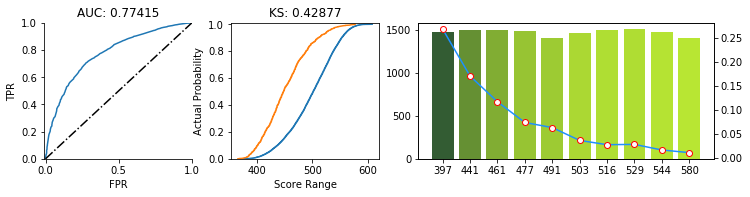

In [6]:
%matplotlib inline
from scorer import Scorer
from score_utils import plot
import math
import pandas as pd

score = Scorer(min_score=300, max_score=850, pdo=30, base_odds=math.exp(3), base=600)

def extract_score(prob):
    return score.to_score(prob[1])

tmp = list(map(lambda x: extract_score(x),model_xgbt.predict_proba(test_df[feats])))
t1 = plot.plot_triple(pd.Series(tmp), y_actual>0, 10, save_plot=True, table=True)

In [4]:
t1

,Score Range,Proportion,Bad Rate,Cumulative of Total Proportion,Cumulative of Good Proportion,Cumulative of Bad Proportion,ks
0,"(364.999, 430.0]",0.100061,0.268788,0.100061,0.079658,0.330008,0.250351
1,"(430.0, 452.0]",0.101619,0.170667,0.201680,0.171412,0.542810,0.371398
2,"(452.0, 470.0]",0.102026,0.116866,0.303706,0.269509,0.689111,0.419602
3,"(470.0, 485.0]",0.101213,0.073628,0.404918,0.371589,0.780549,0.408960
4,"(485.0, 497.0]",0.095725,0.062987,0.500644,0.469243,0.854530,0.385287
5,"(497.0, 510.0]",0.099384,0.036128,0.600027,0.573536,0.898587,0.325051
6,"(510.0, 523.0]",0.101890,0.027261,0.701917,0.681443,0.932668,0.251226
7,"(523.0, 536.0]",0.102229,0.027833,0.804146,0.789644,0.967581,0.177937
8,"(536.0, 552.0]",0.100535,0.016173,0.904681,0.897330,0.987531,0.090201
9,"(552.0, 608.0]",0.095319,0.010661,1.000000,1.000000,1.000000,0.000000


In [4]:
t1.to_csv('test.csv', sep=';')

In [5]:
plot_score

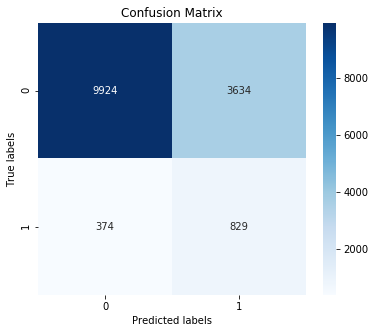

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt     
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# classification report to dataframe
report = classification_report(y_actual, model_xgbt.predict(test_df[feats]), output_dict=True)
df_report = pd.DataFrame(report).transpose()

# confusion matrix plot
plt.figure(figsize=(6,5))
ax = plt.subplot()
cm = confusion_matrix(y_actual, model_xgbt.predict(test_df[feats]))
sns.heatmap(cm, annot=True, ax = ax, cmap="Blues", fmt="g"); #annot=True to annotate cells

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
plt.savefig('plot_confusion_matrix.png')

In [8]:
df_report

,f1-score,precision,recall,support
0,0.831992,0.963682,0.731966,13558.0
1,0.292623,0.185749,0.689111,1203.0
micro avg,0.728474,0.728474,0.728474,14761.0
macro avg,0.562307,0.574716,0.710538,14761.0
weighted avg,0.788034,0.900282,0.728474,14761.0


              precision    recall  f1-score   support

           0       0.96      0.73      0.83     13558
           1       0.18      0.69      0.29      1203

   micro avg       0.73      0.73      0.73     14761
   macro avg       0.57      0.71      0.56     14761
weighted avg       0.90      0.73      0.79     14761

[[9900 3658]
 [ 373  830]]


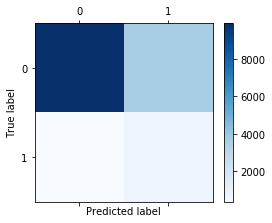

In [144]:
# evaluate metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# classification report
y_pred = model_xgbt.predict(test_df[feats])
print(classification_report(y_actual, y_pred))

# confusion matrix
print(confusion_matrix(y_actual, y_pred))

# plot confusion matrix
plt.matshow(confusion_matrix(y_actual, y_pred), cmap="Blues")
plt.colorbar(shrink=0.8)
plt.xticks(range(2))
plt.yticks(range(2))
plt.xlabel("Predicted label")
plt.ylabel("True label");

### Model Training (Automate Version)

In [147]:
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
import pickle

In [152]:
def kfold_xgb(df, num_folds, stratified=False):
    # divide in training/validation and test data
    train_df = df[df["TARGET"].notnull()]
    test_df = df[df["TARGET"].isnull()]
    del df
    
    # cross validation model
    if stratified:
        folds = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=123)
    else:
        folds = KFold(n_splits=num_folds, shuffle=True, random_state=123)
    
    # create arrays and dataframe to store results
    oof_preds = np.zeros(train_df.shape[0])
    sub_preds = np.zeros(test_df.shape[0])
    feats = [f for f in train_df.columns if f not in ["LN_ID", "TARGET"]]
    
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df["TARGET"])):
        if n_fold == 0: # remove for full K-Fold run
            train_x, train_y = train_df[feats].iloc[train_idx], train_df["TARGET"].iloc[train_idx]
            valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df["TARGET"].iloc[valid_idx]
            
            # set hyperparameter
            param = {'colsample_bytree': 0.758329634688253,
                     'gamma': 0.20600454178220828,
                     'max_depth': 5,
                     'min_child_weight': 2,
                     'reg_alpha': 100,
                     'subsample': 0.7,
                     'scale_pos_weight': 11.3
                    }
            clf = XGBClassifier(**param, n_estimators= 2000)
            clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], eval_metric="auc", verbose=100, early_stopping_rounds=200)
            oof_preds[valid_idx] = clf.predict_proba(valid_x)[:, 1]
            sub_preds += clf.predict_proba(test_df[feats])[:, 1]
            
            print("Fold %2d AUC: %.6f" % (n_fold + 1, roc_auc_score(valid_y, oof_preds[valid_idx])))
            del train_x, train_y, valid_x, valid_y
        
        np.save("xgb_oof_preds_1", oof_preds)
        np.save("xgb_sub_pred_1", sub_preds)
    
    filename = 'model_xgbt_v1'
    return pickle.dump(clf, open(filename, 'wb'))

In [153]:
kfold_xgb(df_, 5, stratified=False)

[0]	validation_0-auc:0.732634	validation_1-auc:0.710272
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 200 rounds.
[100]	validation_0-auc:0.83181	validation_1-auc:0.759757
[200]	validation_0-auc:0.868275	validation_1-auc:0.758208
[300]	validation_0-auc:0.893115	validation_1-auc:0.756932
Stopping. Best iteration:
[111]	validation_0-auc:0.836445	validation_1-auc:0.76043

Fold  1 AUC: 0.760430


In [83]:
xgb_oof_pred = np.load("xgb_oof_preds_1.npy")
xgb_sub_pred = np.load("xgb_sub_pred_1.npy")

In [179]:
df = pickle.load(open("preprocessed_data", "rb"))

In [180]:
df.shape

(76264, 279)

In [183]:
model = pickle.load(open("model_xgbt_v1", "rb"))

              precision    recall  f1-score   support

           0       0.96      0.73      0.83     13558
           1       0.18      0.68      0.29      1203

   micro avg       0.73      0.73      0.73     14761
   macro avg       0.57      0.71      0.56     14761
weighted avg       0.90      0.73      0.79     14761

[[9931 3627]
 [ 383  820]]


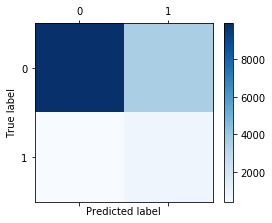

In [184]:
# evaluate metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# classification report
y_pred = model.predict(test_df[feats])
print(classification_report(y_actual, y_pred))

# confusion matrix
print(confusion_matrix(y_actual, y_pred))

# plot confusion matrix
plt.matshow(confusion_matrix(y_actual, y_pred), cmap="Blues")
plt.colorbar(shrink=0.8)
plt.xticks(range(2))
plt.yticks(range(2))
plt.xlabel("Predicted label")
plt.ylabel("True label");